###Data Gathering Overview
At this point in our project, we will be shifting focus from analyzing broad categories of sports data to a more specific subset of sports data. 

For many sports teams' subreddits, the subreddit for that team creates a "Game Thread" for fans of that team to discuss <br>
the games with one another in real time. Here is an example of a game thread for most recent Commanders game: https://www.reddit.com/r/Commanders/comments/yvhapi/game_thread_washington_commanders_at_philadelphia/ <br>

For our external data, we would like to merge data about sports' games with comments from the corresponding game thread.

This could lead to interesting areas to conduct sentiment analysis for the comments if the team performed poorly, or inversely positive sentiment for the comments <br>
if the team performed well. There are also potentially interesting areas for machine learning applications.

For this analysis, we will choose the New York Yankees subreddit, as it (unfortunately) has an extremely active fanbase with many comments in each game thread. <br>
Our external data we will use to merge with the comments of these game threads will be game data from each Yankee's game from the 2021 season from https://www.baseball-reference.com. <br>
The link to our external dataset can be found here: https://www.baseball-reference.com/teams/NYY/2021-schedule-scores.shtml

Within the Yankees subreddit, each game thread is posted by a bot called "YankeesBot". <br>
We will seek to pull all threads from the 2021 yankees baseball season with the title "Game Thread" in <br>
order to retrieve each Game Thread submission. Once we have all of the submissions, we can <br>
later join comments with the submission posts to find all of the comments for each game thread. <br>

We'll start this process here, each step is marked below with a corresponding comment.

In [0]:
from pyspark.sql.functions import *
#Selecting post game threads from the commanders subreddithttps://adb-265272803014794.14.azuredatabricks.net/?o=265272803014794#
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

#filtering out posts only from Yankees
yankees_gt = submissions.filter( col("subreddit") == "NYYankees" )
#filtering posts to only be from the Yankees subreddit bot that makes the game threads
yankees_gt = yankees_gt.filter(col('author') == 'Yankeebot')
#converting to utc
yankees_gt = yankees_gt.withColumn("created_utc", from_unixtime(col("created_utc")))
#selecting Yankees games from the 2021 season (between the dates of the first and last game)
yankees_gt = yankees_gt.filter( (col("created_utc") > unix_timestamp(lit('2021-04-01 00:00:00')).cast('timestamp')) & \
                                   (col("created_utc") < unix_timestamp(lit('2021-10-05 00:00:00')).cast('timestamp')))
#Filtering to only include posts that include "Game Thread" in the title to retrieve the game thread posts
yankees_gt = yankees_gt.filter(col("title").rlike("Game Thread:*."))

We should expect to see 162 game threads, 1 for each game of the baseball season. Let's see how many we get with a simple count command.

In [0]:
yankees_gt.count()#result was 169, will need to rerun at some point

Out[12]: 169

Interesting! It seems that we have 169 games, indicating the bot may have created duplicate values or mistakenly created threads.<br>
Threads with the least number of comments are more likely to be mistaken posts, duplicates, or outliers. <br>
Since we need exactly 162 games to conduct this analysis, let's select 10 game threads with the least amount of comments to examine what the issue is. <br>

In [0]:
yankees_gt.select('id', 'title', 'created_utc', 'num_comments', 'permalink').orderBy('num_comments').limit(10).show(truncate = False)#need to reun result table

+------+----------------------------------------------------------------------------------+-------------------+------------+-------------------------------------------------------------------------------+
|id    |title                                                                             |created_utc        |num_comments|permalink                                                                      |
+------+----------------------------------------------------------------------------------+-------------------+------------+-------------------------------------------------------------------------------+
|mi7zci|Game Thread: Blue Jays (1-0) @ Yankees (0-1) - April 01, 2021 @ 01:05 PM EDT      |2021-04-01 23:36:08|14          |/r/NYYankees/comments/mi7zci/game_thread_blue_jays_10_yankees_01_april_01_2021/|
|p95zxp|Post Game Thread: The Yankees Game is Postponed - August 22, 2021 @ 01:05 PM EDT  |2021-08-22 04:26:16|39          |/r/NYYankees/comments/p95zxp/post_game_thread_the_yankee

After examining these game threads by viewing the submission link, it is clear from viewing the comments that all of these games were postponed. <br>
We'll remove each of these links corresponding to a "postponed" game. <br>

It's a fairly easy process to manually filter out the id's of those links from the table, so we'll do that to filter out the bad threads.

In [0]:
yankees_gt = yankees_gt.filter(col('id') != 'p95zxp') #postponed game 1
yankees_gt = yankees_gt.filter(col('id') != 'obnptv') #postponed game 2
yankees_gt = yankees_gt.filter(col('id') != 'nlrhbn') #postponed game 3
yankees_gt = yankees_gt.filter(col('id') != 'nlrhbk') #postponed game 4
yankees_gt = yankees_gt.filter(col('id') != 'ocni31') #postponed game 5
yankees_gt = yankees_gt.filter(col('id') != 'ocjfck') #postponed game 6
yankees_gt = yankees_gt.filter(col('id') != 'ol1j32') #postponed game 7
yankees_gt = yankees_gt.filter(col('id') != 'oboakd') #postponed game 7

In [0]:
yankees_gt.count()

Out[15]: 161

Unfortunately, we now have only 161 games, meaning that 1 game thread for a corresponding game is missing from our dataset. However, this is not necessarily <br>
an issue, as we can simply join each date value for each game thread with the date values from our external data. Game threads are created on the same day <br>
as the game, so this method will be perfect to conduct our join. In order to do this, we will need to convert the timestamp to a date_time object.

In [0]:
yankees_gt.withColumn('date_val', to_date(col('created_utc'))).select('created_utc', 'date_val').limit(5).show(truncate = False)

+-------------------+----------+
|created_utc        |date_val  |
+-------------------+----------+
|2021-05-05 21:04:32|2021-05-05|
|2021-04-14 15:07:03|2021-04-14|
|2021-06-25 21:09:32|2021-06-25|
|2021-04-22 20:09:58|2021-04-22|
|2021-06-28 21:04:28|2021-06-28|
+-------------------+----------+



In [0]:
yankees_gt = yankees_gt.withColumn('date_val', to_date(col('created_utc')))

Now let's bring in our external data. We'll examine it quickly by using the head command to see what variables we can work with.

In [0]:
import pandas as pd
yankees_game_data = pd.read_csv("/Workspace/Repos/xn19@georgetown.edu/fall-200-project-eda-adb-project-group-22/data/csv/yankees.csv")
yankees_game_data.head()

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
0,1,Thursday Apr 1,boxscore,NYY,NaN,TOR,L,2,3,10.0,...,1.0,Romano,Nelson,Merryweather,3:44,D,10850.0,1.09,-,NaN
1,2,Saturday Apr 3,boxscore,NYY,NaN,TOR,W,5,3,NaN,...,1.0,Loaisiga,Stripling,Green,3:38,D,10107.0,0.97,+,NaN
2,3,Sunday Apr 4,boxscore,NYY,NaN,TOR,L,1,3,NaN,...,2.0,Borucki,German,Merryweather,2:41,D,10066.0,1.02,-,NaN
3,4,Monday Apr 5,boxscore,NYY,NaN,BAL,W,7,0,NaN,...,1.0,Montgomery,Lopez,NaN,2:58,N,9008.0,1.04,+,NaN
4,5,Tuesday Apr 6,boxscore,NYY,NaN,BAL,W,7,2,NaN,...,Tied,Cole,Kremer,NaN,2:58,N,9404.0,1.03,++,NaN


We'll need to do some minor operations to our external data in order to merge it with our reddit dataset.<br>
To do this, we'll do two simple operations:<br>
1. Make a date variable with the proper year/format <br>
2. Filter out games less than nine innings. Games less than 9 innings will include double headers (double headers are 7 innings) and games that were postponed. <br>

Double headers are games that are on the same date. We don't want to include these, as we would run into issues when trying to join <br>
games on the date value with our reddit data if we have multiple games/reddit threads with the same date.

In [0]:
yankees_game_data['New_Date'] = yankees_game_data['Date'].str.replace(r'^\w+', '2021')
yankees_game_data = yankees_game_data[~(yankees_game_data['Inn'] < 9)]
yankees_game_data['New_Date'] = pd.to_datetime(yankees_game_data['New_Date'])
yankees_game_data

<command-3721090232816668>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  yankees_game_data['New_Date'] = yankees_game_data['Date'].str.replace(r'^\w+', '2021')


,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,New_Date
0,1,Thursday Apr 1,boxscore,NYY,NaN,TOR,L,2,3,10.0,...,Romano,Nelson,Merryweather,3:44,D,10850.0,1.09,-,NaN,2021-04-01
1,2,Saturday Apr 3,boxscore,NYY,NaN,TOR,W,5,3,NaN,...,Loaisiga,Stripling,Green,3:38,D,10107.0,0.97,+,NaN,2021-04-03
2,3,Sunday Apr 4,boxscore,NYY,NaN,TOR,L,1,3,NaN,...,Borucki,German,Merryweather,2:41,D,10066.0,1.02,-,NaN,2021-04-04
3,4,Monday Apr 5,boxscore,NYY,NaN,BAL,W,7,0,NaN,...,Montgomery,Lopez,NaN,2:58,N,9008.0,1.04,+,NaN,2021-04-05
4,5,Tuesday Apr 6,boxscore,NYY,NaN,BAL,W,7,2,NaN,...,Cole,Kremer,NaN,2:58,N,9404.0,1.03,++,NaN,2021-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,158,Wednesday Sep 29,boxscore,NYY,@,TOR,L,5,6,NaN,...,Cimber,Holmes,Romano,2:52,N,29601.0,1.00,-,NaN,2021-09-29
158,159,Thursday Sep 30,boxscore,NYY,@,TOR,W,6,2,NaN,...,King,Ray,NaN,3:29,N,29659.0,2.18,+,NaN,2021-09-30
159,160,Friday Oct 1,boxscore,NYY,NaN,TBR,L,3,4,NaN,...,Head,Cortes,Kittredge,3:25,N,41469.0,0.54,-,NaN,2021-10-01
160,161,Saturday Oct 2,boxscore,NYY,NaN,TBR,L,2,12,NaN,...,Patino,Montgomery,NaN,3:26,D,41648.0,1.01,--,NaN,2021-10-02


In [0]:
#Creating a spark data frame
yankees_game_data = spark.createDataFrame(yankees_game_data)

In [0]:
yankees_game_data.join(yankees_gt, yankees_game_data.New_Date == yankees_gt.date_val, "inner").count()

Out[23]: 154

This leaves us with 154 games left to work with for the 2021 season. Looks good!

Now let's join our external data with the reddit data based on the date value. Game threads will have the same date as the game on which they are played, as discussed above.

In [0]:
yankees_df = yankees_game_data.join(yankees_gt, yankees_game_data.New_Date == yankees_gt.date_val, "inner")

Now, in order to join our combined dataset with comments, we will need to create a new variable link_id that has a "t3_" flag before the id. <br>
Comments are identified by the submission in which they are under by this t3_ flag, so we will need this variable in order to join the datasets.

In [0]:
yankees_df = yankees_df.withColumn('link_id', concat(lit("t3_"), col('id')))

Let's also see a snippet of the data to make sure everything looks good and corresponds together by selecting a couple variables from each of our original datasets.

In [0]:
yankees_df.select('title', 'New_Date', 'date_val', 'W/L').limit(5).show(truncate = False)

+-----------------------------------------------------------------------------+-------------------+----------+----+
|title                                                                        |New_Date           |date_val  |W/L |
+-----------------------------------------------------------------------------+-------------------+----------+----+
|Game Thread: Astros (15-14) @ Yankees (15-14) - May 05, 2021 @ 07:05 PM EDT  |2021-05-05 00:00:00|2021-05-05|W   |
|Game Thread: Yankees (5-6) @ Blue Jays (5-6) - April 14, 2021 @ 01:07 PM EDT |2021-04-14 00:00:00|2021-04-14|L-wo|
|Game Thread: Yankees (40-34) @ Red Sox (44-31) - June 25, 2021 @ 07:10 PM EDT|2021-06-25 00:00:00|2021-06-25|L   |
|Game Thread: Yankees (6-11) @ Indians (8-8) - April 22, 2021 @ 06:10 PM EDT  |2021-04-22 00:00:00|2021-04-22|W   |
|Game Thread: Angels (37-40) @ Yankees (40-37) - June 28, 2021 @ 07:05 PM EDT |2021-06-28 00:00:00|2021-06-28|L   |
+-----------------------------------------------------------------------

Now let's save the data into a parquet for future use. We will not save the dataset with the comments joined, as that would be a significant amount of storage to <br>
save into dbfs. Instead, we can simply use a join when we would like to use the data.

In [0]:
#yankees_df.write.parquet("/FileStore/yankees/yankees_df.parquet")


Now, we'll read in the data when necessary and join it with the comments to conduct our analysis.

In [0]:
#TO READ IN NEW DATA
from pyspark.sql.functions import *
yankees = spark.read.parquet("/FileStore/yankees/yankees_df.parquet")
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")


In [0]:
#joining each comment that was made for each post game thread with the full game stats

## below code is from https://stackoverflow.com/questions/38798567/pyspark-rename-more-than-one-column-using-withcolumnrenamed to deal with columns with same name but actually different content. In this way, we keep all the columns in comments and submissions.
def rename_columns(df, columns):
    if isinstance(columns, dict):
        return df.select(*[col(col_name).alias(columns.get(col_name, col_name)) for col_name in df.columns])
    else:
        raise ValueError("'columns' should be a dict, like {'old_name_1':'new_name_1', 'old_name_2':'new_name_2'}")
        
comments=comments.transform(lambda df: rename_columns(df, {'author_cakeday':'author_cakeday_cm', 'author_flair_css_class':'author_flair_css_class_cn','author_flair_text':'author_flair_text_cm', 'author':'author_cm', 'created_utc':'created_utc_cm', 'distinguished':'distinguished_cm', 'edited':'edited_cm', 'gilded':'gilded_cm', 'id':'id_cm', 'link_id':'link_id_cm', 'permalink':'permalink_cm', 'retrieved_on':'retrieved_on_cm', 'score':'score_cm', 'stickied':'stickied_cm', 'subreddit_id':'subreddit_id_cm', 'subreddit':'subreddit_cm'}))

#joining each comment that was made for each post game thread with the full game stats
yankees_full = yankees.join(comments, yankees.link_id == comments.link_id_cm, "inner").cache()

Let's check the count quickly to make sure there are an expectedly large amount of comments from our dataset:

In [0]:
#this took an absursdly long amount of time, now sure how we can avoid that in the future
yankees_full.count()
#yankees_full.write.parquet("/FileStore/yankees_with_external/yankees_with_external.parquet")

Out[29]: 619333

We have roughly 600k rows, corresponding to 600k comments across all of our game threads!

In [0]:
yankees = spark.read.parquet("/FileStore/yankees/yankees_df.parquet")

In [0]:
yankees_wl = yankees.select('W/L').groupBy('W/L').count()
yankees_wl = yankees_wl.toPandas().set_index('W/L')
yankees_wl

,count
W/L,
W-wo,11
L,59
W,75
L-wo,9


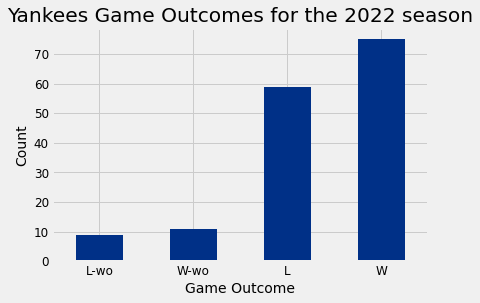

In [0]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
yankees_wl = yankees_wl.sort_values('count')
yankees_wl.plot.bar(title='Yankees Game Outcomes for the 2022 season', fontsize=12, legend = None, color='#003087')
plt.xlabel('Game Outcome', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation = 0)
plt.show()

In [0]:
yankees_wl_comcount = yankees.select('W/L', 'num_comments').groupBy('W/L').sum('num_comments').toPandas().set_index('W/L')
yankees_wl_comcount.columns = ['num_comments']
yankees_wl_comcount = yankees_wl_comcount.sort_values('num_comments')
yankees_wl_comcount

,num_comments
W/L,
L-wo,41193
W-wo,50579
L,207935
W,295769


In [0]:
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

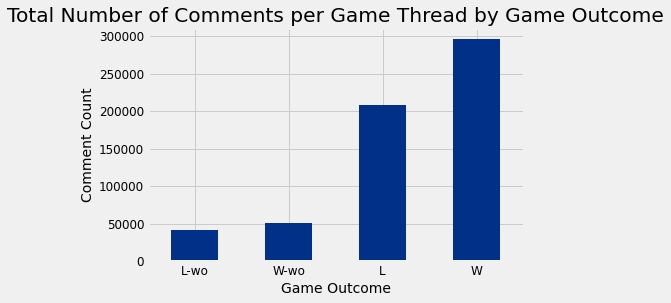

In [0]:
plt.style.use('fivethirtyeight')
yankees_wl_comcount.plot.bar(title='Total Number of Comments per Game Thread by Game Outcome', fontsize=12, legend = None, color='#003087')
plt.xlabel('Game Outcome', fontsize=14)
plt.ylabel('Comment Count', fontsize=14)
plt.xticks(rotation = 0)
plt.show()

# Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, '.png')
plt.savefig(plot_fpath)
plt.show()

In [0]:
yankees_wl_avgcom = yankees.select('W/L', 'num_comments').groupBy('W/L').avg('num_comments').toPandas().set_index('W/L')
yankees_wl_avgcom.columns = ['avg_comments']
yankees_wl_avgcom = yankees_wl_avgcom.sort_values('avg_comments')
yankees_wl_avgcom

,avg_comments
W/L,
L,3524.322034
W,3943.586667
L-wo,4577.000000
W-wo,4598.090909


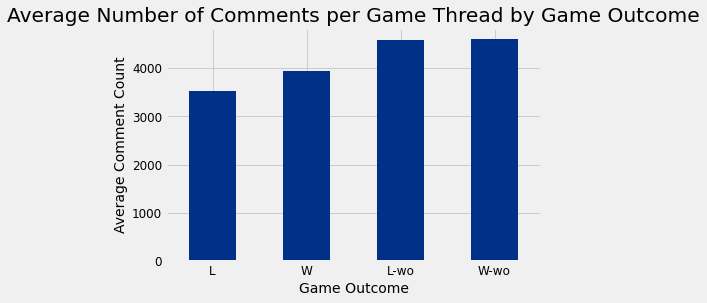

In [0]:
yankees_wl_avgcom.plot.bar(title='Average Number of Comments per Game Thread by Game Outcome', fontsize=12, legend = None, color='#003087')
plt.xlabel('Game Outcome', fontsize=14)
plt.ylabel('Average Comment Count', fontsize=14)
plt.xticks(rotation = 0)
plt.show()